# Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import psycopg2 as pg
import re
import steffen.cbioportal.data as cbd
from scipy.stats import ttest_ind
from collections import Counter
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data access

## from excel file

In [2]:
cipl = pd.read_excel('../data/overview_cipl_pitches.xlsx')

## from database

In [6]:
# establish connection
conn = pg.connect('dbname=cbiodb host=wdec005438 user=postgres password=postgres')

In [7]:
# get expression data
expr = pd.read_sql("SELECT * from rnaseqdb.expression where symbol = 'TP53'", conn)

In [9]:
expr_slice = expr.set_index('sample_barcode').query('sample_type == "tumor"')

## from web

In [10]:
# get studies from cbioportal
studies = cbd.get_tcga_provisional_studies()

In [11]:
a
# get mutation data
mut = cbd.get_mutations(studies.cancer_study_id.tolist(), ['TP53'])a


In [12]:
mut.head()

,TP53_MUT,cancer_study_id
TCGA-AB-2802-03,NaN,laml_tcga
TCGA-AB-2803-03,NaN,laml_tcga
TCGA-AB-2804-03,NaN,laml_tcga
TCGA-AB-2805-03,NaN,laml_tcga
TCGA-AB-2806-03,NaN,laml_tcga


# data cleaning/reformatting/shaping

In [13]:
# cut type from index
mut.index = [ele[:12] for ele in mut.index]

In [14]:
# set na to wildtype
mut = mut.fillna('wt')

In [15]:
# join mutation and expression data
joined = mut.join(expr_slice)

In [16]:
joined.head()

,TP53_MUT,cancer_study_id,symbol,entrezid,log2_tpm,sample_type,data_source,tissue_type,tissue_subtype,cancer_type
TCGA-02-0003,"R282W,H178Q",gbm_tcga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0033,R248Q,gbm_tcga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0047,wt,gbm_tcga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0055,V216M,gbm_tcga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-2470,wt,gbm_tcga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# keep only rows with expression data
joined = joined.dropna(subset = ['log2_tpm'])

In [18]:
joined.head()

,TP53_MUT,cancer_study_id,symbol,entrezid,log2_tpm,sample_type,data_source,tissue_type,tissue_subtype,cancer_type
TCGA-05-4249,wt,luad_tcga,TP53,7157.0,10.47,tumor,tcga,lung,None,luad
TCGA-05-4382,V272G,luad_tcga,TP53,7157.0,9.45,tumor,tcga,lung,None,luad
TCGA-05-4384,Y205C,luad_tcga,TP53,7157.0,10.25,tumor,tcga,lung,None,luad
TCGA-05-4389,wt,luad_tcga,TP53,7157.0,9.47,tumor,tcga,lung,None,luad
TCGA-05-4390,wt,luad_tcga,TP53,7157.0,9.63,tumor,tcga,lung,None,luad


In [19]:
# set all mutated to mut
joined['TP53_MUTCALL'] = joined.apply(lambda x: 'wt' if x.TP53_MUT == "wt" else "mut", axis = 1)

In [20]:
MISSENSE = re.compile('[A-Z]\d+[A-Z]')

In [21]:
MISSENSE.match('A234V')

<_sre.SRE_Match object; span=(0, 5), match='A234V'>

In [22]:
MISSENSE.match('A123123T')

<_sre.SRE_Match object; span=(0, 8), match='A123123T'>

In [23]:
def muttype_call_tp53(data):
    if data.TP53_MUT == "wt":
        return "wt"
    if "*" in data.TP53_MUT or 'fs' in data.TP53_MUT:
        return 'lof'
    if MISSENSE.match(data.TP53_MUT):
        return 'missense'
    return None

In [24]:
joined['TP53_MUTCALL_FINE'] = joined.apply(muttype_call_tp53, axis = 1)

In [26]:
joined.TP53_MUTCALL.value_counts()

wt     2941
mut    1465
Name: TP53_MUTCALL, dtype: int64

# visualization

In [27]:
# some viz parameters
sns.set_context('talk')
sns.set_style('white')

## plot expression against mutation

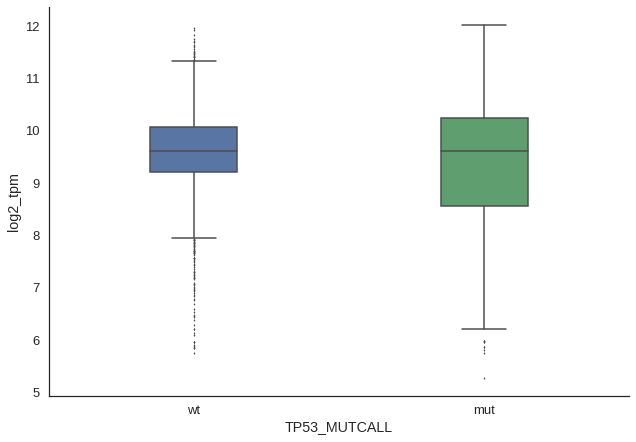

In [28]:
sns.boxplot(data = joined, x = 'TP53_MUTCALL', y = 'log2_tpm', width = 0.3, linewidth = 1.5, fliersize = 2)
sns.despine()

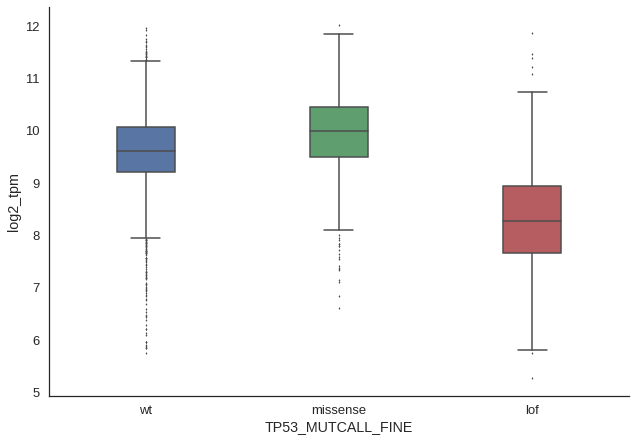

In [29]:
sns.boxplot(data = joined, x = 'TP53_MUTCALL_FINE', y = 'log2_tpm', width = 0.3, linewidth = 1.5, fliersize = 2)
sns.despine()

## who pitched most?

In [89]:
cipl.Presenter.value_counts()

Andreas Steffen                                    4
Florian Sohler                                     3
Lena Willkomm                                      3
Barbara Nicke                                      2
Daniel Freitag                                     2
Michael Steckel                                    2
Helge Roider, Andreas Steffen                      2
Justus Veerkamp, Daniel Freitag                    1
Kirsten Leineweber                                 1
Alexandra Becker                                   1
Alexander Zink                                     1
Holger Trucks                                      1
Benjamin Georgi, Daniel Freitag, Florian Sohler    1
Andreas Steffen, Daniel Freitag                    1
Stephan Decker                                     1
Luisella Toschi                                    1
Benjamin Georgi                                    1
Michael Becker, Ralf Lesche                        1
Name: Presenter, dtype: int64

In [91]:
listlist = [ele1.split(',') for ele1 in cipl.Presenter.tolist()]

In [95]:
presenter = [item.strip() for sublist in listlist for item in sublist]

In [117]:
num_pitches = pd.DataFrame.from_dict(Counter(presenter), orient='index').rename(columns = {0:'number_of_pitches'}).sort_values('number_of_pitches', ascending = True)

In [118]:
num_pitches.reset_index()

,index,number_of_pitches
0,Kirsten Leineweber,1
1,Alexandra Becker,1
2,Justus Veerkamp,1
3,Stephan Decker,1
4,Luisella Toschi,1
5,Holger Trucks,1
6,Michael Becker,1
7,Ralf Lesche,1
8,Alexander Zink,1
9,Michael Steckel,2


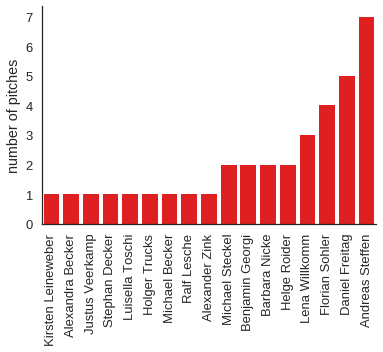

In [119]:
sns.barplot(data = num_pitches.reset_index(), x = 'index', y = 'number_of_pitches', color = 'red')
plt.xticks(rotation = 90)
sns.despine()
plt.xlabel('')
plt.ylabel('number of pitches')

# statistics

## is there a significant difference between lof and wt?

In [58]:
wt = joined.query('TP53_MUTCALL_FINE == "wt"').log2_tpm.tolist()
lof = joined.query('TP53_MUTCALL_FINE == "lof"').log2_tpm.tolist()

In [61]:
t,p = ttest_ind(wt, lof)

In [63]:
print("pval: {p}, t: {t}".format(p=p, t=t))

pval: 2.02330897439995e-178, t: 30.290231327742212
